# Customer Life Time Value
Customer lifetime value is how much money a customer will bring your brand throughout their entire time as a paying customer.

At a glance, it tells you how much a customer is worth to your brand and gives you insight into their overall value. From there, you’ll have a better understanding of how much you should be investing in customer retention going forward.

In [1]:
import gc
import os
import time
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from collections import defaultdict

In [2]:
ls

Market_Basket_Analysis_Customer_Life_Time_Value.ipynb
Market_Basket_Analysis_Customer_Segmentation_Retention.ipynb
market_basket_analysis.ipynb
online_retail.xlsx


In [3]:
df=pd.read_excel('online_retail.xlsx')

In [4]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


In [5]:
# -- Convert InvoiceDate from object to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [7]:
#Drop Records Without Customer ID and Invoice
df.dropna(axis=0, subset=['Customer ID'], inplace=True)
df.dropna(axis=0, subset=['Invoice'], inplace=True)

In [8]:
#PreProcessing of the data
# Drop cancelled orders
df = df.loc[df['Quantity'] > 0]

# Drop incomplete month
df = df.loc[df['InvoiceDate'] < '2010-12-01']

# Calculate total sales from the Quantity and UnitPrice
df['Sales'] = df['Quantity'] * df['Price']

In [11]:
'''
Here we group the dataframe by CustimerID and InvoiceNo and 
aggregate the Sales column as well as the InvoiceDate, to create a fianl dataset
'''

orders_df = df.groupby(['Customer ID', 'Invoice']).agg({
    'Sales': sum,
    'InvoiceDate': max
})

orders_df.head()

Sales         InvoiceDate
Customer ID Invoice                           
12346.0     491725    45.0 2009-12-14 08:34:00
            491742    22.5 2009-12-14 11:00:00
            491744    22.5 2009-12-14 11:02:00
            492718    22.5 2009-12-18 10:47:00
            492722     1.0 2009-12-18 10:55:00

In [12]:
orders_df

Sales         InvoiceDate
Customer ID Invoice                             
12346.0     491725     45.00 2009-12-14 08:34:00
            491742     22.50 2009-12-14 11:00:00
            491744     22.50 2009-12-14 11:02:00
            492718     22.50 2009-12-18 10:47:00
            492722      1.00 2009-12-18 10:55:00
...                      ...                 ...
18286.0     519785    833.48 2010-08-20 11:57:00
18287.0     508581   1071.61 2010-05-17 11:55:00
            523289    862.00 2010-09-21 12:17:00
            523290     30.60 2010-09-21 12:19:00
            534346    381.50 2010-11-22 11:51:00

[18439 rows x 2 columns]

In [13]:
'''
For the preparation of the data for descriptive part we need the following functions:
'''


def groupby_mean(x):
    return x.mean()

def groupby_count(x):
    return x.count()

def purchase_duration(x):
    return (x.max() - x.min()).days

def avg_frequency(x):
    return (x.max() - x.min()).days/x.count()

groupby_mean.__name__ = 'avg'
groupby_count.__name__ = 'count'
purchase_duration.__name__ = 'purchase_duration'
avg_frequency.__name__ = 'purchase_frequency'

In [15]:
'''
Re-group the record by CustomerID and aggregate the Sales and InvoiceDate columns with the previously created functions
'''

summary_df = orders_df.reset_index().groupby('Customer ID').agg({
    'Sales': [min, max, sum, groupby_mean, groupby_count],
    'InvoiceDate': [min, max, purchase_duration, avg_frequency]
})

summary_df.head()

Sales                                             InvoiceDate  \
                min      max      sum         avg count                 min   
Customer ID                                                                   
12346.0        1.00   142.31   372.86   33.896364    11 2009-12-14 08:34:00   
12347.0      611.53   611.53   611.53  611.530000     1 2010-10-31 14:20:00   
12348.0      222.16   222.16   222.16  222.160000     1 2010-09-27 14:59:00   
12349.0      200.00  1402.62  2671.14  890.380000     3 2010-04-29 13:20:00   
12351.0      300.93   300.93   300.93  300.930000     1 2010-11-29 15:23:00   

                                                                      
                            max purchase_duration purchase_frequency  
Customer ID                                                           
12346.0     2010-06-28 13:53:00               196          17.818182  
12347.0     2010-10-31 14:20:00                 0           0.000000  
12348.0     2010-09-27 14:59:00                 0           0.000000  
12349.0     2010-10-28 08:23:00               181          60.333333  
12351.0     2010-11-29 15:23:00                 0           0.000000

In [16]:
'''
Clean a little bit
'''
summary_df.columns = ['_'.join(col).lower() for col in summary_df.columns]
summary_df = summary_df.reset_index()
summary_df.head()


,Customer ID,sales_min,sales_max,sales_sum,sales_avg,sales_count,invoicedate_min,invoicedate_max,invoicedate_purchase_duration,invoicedate_purchase_frequency
0,12346.0,1.00,142.31,372.86,33.896364,11,2009-12-14 08:34:00,2010-06-28 13:53:00,196,17.818182
1,12347.0,611.53,611.53,611.53,611.530000,1,2010-10-31 14:20:00,2010-10-31 14:20:00,0,0.000000
2,12348.0,222.16,222.16,222.16,222.160000,1,2010-09-27 14:59:00,2010-09-27 14:59:00,0,0.000000
3,12349.0,200.00,1402.62,2671.14,890.380000,3,2010-04-29 13:20:00,2010-10-28 08:23:00,181,60.333333
4,12351.0,300.93,300.93,300.93,300.930000,1,2010-11-29 15:23:00,2010-11-29 15:23:00,0,0.000000


In [17]:
summary_df = summary_df.loc[summary_df['invoicedate_purchase_duration'] > 0]
summary_df.shape

(2754, 10)

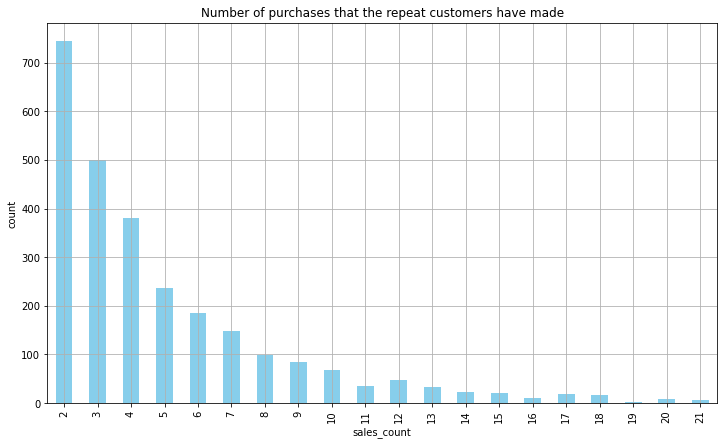

In [18]:
'''
This plot shows the distributions of the number of purchases that the repeat customers have made
'''

ax = summary_df.groupby('sales_count').count()['sales_avg'][:20].plot(
    kind='bar', 
    color='skyblue',
    figsize=(12,7), 
    grid=True
)

ax.set_ylabel('count')
plt.title('Number of purchases that the repeat customers have made')

plt.show()

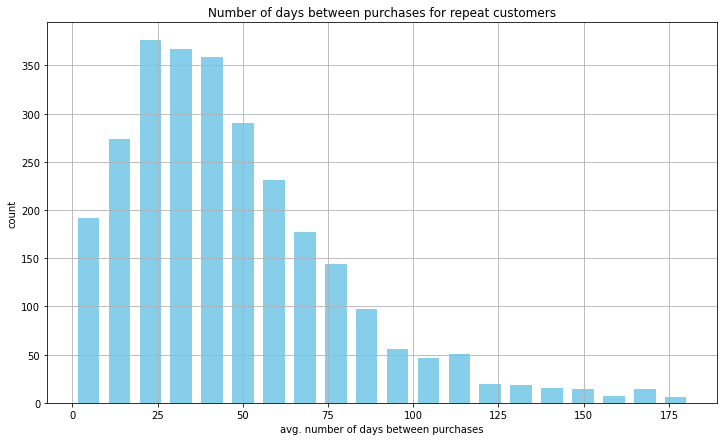

In [19]:
'''
This plot shows the average number of days between purchases for repeat customers.
It is an overall view of how frequently repeat customers made purchases historically.
'''

ax = summary_df['invoicedate_purchase_frequency'].hist(
    bins=20,
    color='skyblue',
    rwidth=0.7,
    figsize=(12,7)
)

ax.set_xlabel('avg. number of days between purchases')
ax.set_ylabel('count')
plt.title('Number of days between purchases for repeat customers')

plt.show()

# Predicting 3 Month Customer Life Time Value

In [20]:
# Determine the frequency
clv_freq = '3M'

# Group by CustomerID 
# Break down the data into chunks of 3 months for each customer
# Aggregate the sales column by sum
# Aggregate the sales column by average_sum and count (both with the previous created functions)
data_df = orders_df.reset_index().groupby([
    'Customer ID',
    pd.Grouper(key='InvoiceDate', freq=clv_freq)
]).agg({
    'Sales': [sum, groupby_mean, groupby_count],
})

# Bring the dataset in a readable format
data_df.columns = ['_'.join(col).lower() for col in data_df.columns]
data_df = data_df.reset_index()
data_df.head()

,Customer ID,InvoiceDate,sales_sum,sales_avg,sales_count
0,12346.0,2009-12-31,113.50,22.70,5
1,12346.0,2010-03-31,117.05,23.41,5
2,12346.0,2010-06-30,142.31,142.31,1
3,12347.0,2010-12-31,611.53,611.53,1
4,12348.0,2010-09-30,222.16,222.16,1


In [22]:
#We will now encode the InvoiceDate column values so that they are easier to read than the current date format.
# Set the length of the column InvoiceDate. In our case = 10
length_of_InvoiceDate = 10

date_month_map = {
    str(x)[:length_of_InvoiceDate]: 'M_%s' % (i+1) for i, x in enumerate(
        sorted(data_df.reset_index()['InvoiceDate'].unique(), reverse=True)
    )
}
date_month_map

{'2010-12-31': 'M_1',
 '2010-09-30': 'M_2',
 '2010-06-30': 'M_3',
 '2010-03-31': 'M_4',
 '2009-12-31': 'M_5'}

In [23]:
'''
Apply the generated dictionary to the dataframe for prediction models
'''

data_df['M'] = data_df['InvoiceDate'].apply(lambda x: date_month_map[str(x)[:length_of_InvoiceDate]])
data_df.head(10)

,Customer ID,InvoiceDate,sales_sum,sales_avg,sales_count,M
0,12346.0,2009-12-31,113.50,22.70,5,M_5
1,12346.0,2010-03-31,117.05,23.41,5,M_4
2,12346.0,2010-06-30,142.31,142.31,1,M_3
3,12347.0,2010-12-31,611.53,611.53,1,M_1
4,12348.0,2010-09-30,222.16,222.16,1,M_2
5,12349.0,2010-06-30,1268.52,634.26,2,M_3
6,12349.0,2010-12-31,1402.62,1402.62,1,M_1
7,12351.0,2010-12-31,300.93,300.93,1,M_1
8,12352.0,2010-12-31,343.80,171.90,2,M_1
9,12353.0,2010-12-31,317.76,317.76,1,M_1


# We are ready to create a sample set with features and target variables. In this case, we are going to use the last 3 months as the target variable and the rest as the features. In other words, we are going to train a machie learning model that predicts the last 3 months’customer value with the rest of the data

In [24]:
# Exclude M_1 because this will be our predictor variable.
features_df = pd.pivot_table(
    data_df.loc[data_df['M'] != 'M_1'], 
    values=['sales_sum', 'sales_avg', 'sales_count'], 
    columns='M', 
    index='Customer ID'
)

# Prepare the features dataframe for better view
features_df.columns = ['_'.join(col) for col in features_df.columns]

# Encode NaN values with 0.0
features_df = features_df.fillna(0)
features_df

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5
Customer ID,,,,,,,,,,,,
12346.0,0.00,142.31,23.41,22.70,0.0,1.0,5.0,5.0,0.00,142.31,117.05,113.50
12348.0,222.16,0.00,0.00,0.00,1.0,0.0,0.0,0.0,222.16,0.00,0.00,0.00
12349.0,0.00,634.26,0.00,0.00,0.0,2.0,0.0,0.0,0.00,1268.52,0.00,0.00
12355.0,0.00,488.21,0.00,0.00,0.0,1.0,0.0,0.0,0.00,488.21,0.00,0.00
12358.0,0.00,268.10,0.00,1429.83,0.0,1.0,0.0,1.0,0.00,268.10,0.00,1429.83
...,...,...,...,...,...,...,...,...,...,...,...,...
18281.0,0.00,120.32,0.00,0.00,0.0,1.0,0.0,0.0,0.00,120.32,0.00,0.00
18283.0,92.00,0.00,118.14,0.00,1.0,0.0,3.0,0.0,92.00,0.00,354.42,0.00
18285.0,0.00,0.00,427.00,0.00,0.0,0.0,1.0,0.0,0.00,0.00,427.00,0.00


In [25]:
# Just select M_1 because this is our target variable
response_df = data_df.loc[
    data_df['M'] == 'M_1',
    ['Customer ID', 'sales_sum']
]

# Rename the columns accordingly
response_df.columns = ['Customer ID', 'CLV_'+clv_freq]
response_df

,Customer ID,CLV_3M
3,12347.0,611.53
6,12349.0,1402.62
7,12351.0,300.93
8,12352.0,343.80
9,12353.0,317.76
...,...,...
9300,18278.0,240.30
9302,18280.0,307.55
9306,18283.0,195.35
9307,18284.0,461.68


In [26]:
# Join the features_df and response_df  on CustomerID
sample_set_df = features_df.merge(
    response_df, 
    left_index=True, 
    right_on='Customer ID',
    how='left'
)

# Encode NaN values with 0.0
sample_set_df = sample_set_df.fillna(0)

sample_set_df

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5,Customer ID,CLV_3M
NaN,0.00,142.31,23.41,22.70,0.0,1.0,5.0,5.0,0.00,142.31,117.05,113.50,12346.0,0.00
NaN,222.16,0.00,0.00,0.00,1.0,0.0,0.0,0.0,222.16,0.00,0.00,0.00,12348.0,0.00
6.0,0.00,634.26,0.00,0.00,0.0,2.0,0.0,0.0,0.00,1268.52,0.00,0.00,12349.0,1402.62
NaN,0.00,488.21,0.00,0.00,0.0,1.0,0.0,0.0,0.00,488.21,0.00,0.00,12355.0,0.00
15.0,0.00,268.10,0.00,1429.83,0.0,1.0,0.0,1.0,0.00,268.10,0.00,1429.83,12358.0,1021.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,0.00,120.32,0.00,0.00,0.0,1.0,0.0,0.0,0.00,120.32,0.00,0.00,18281.0,0.00
9306.0,92.00,0.00,118.14,0.00,1.0,0.0,3.0,0.0,92.00,0.00,354.42,0.00,18283.0,195.35
NaN,0.00,0.00,427.00,0.00,0.0,0.0,1.0,0.0,0.00,0.00,427.00,0.00,18285.0,0.00
NaN,833.48,0.00,0.00,462.95,1.0,0.0,0.0,1.0,833.48,0.00,0.00,462.95,18286.0,0.00


In [27]:
#Train Test Split
target_var = 'CLV_'+clv_freq
all_features = [x for x in sample_set_df.columns if x not in ['Customer ID', target_var]]

In [28]:
all_features

['sales_avg_M_2',
 'sales_avg_M_3',
 'sales_avg_M_4',
 'sales_avg_M_5',
 'sales_count_M_2',
 'sales_count_M_3',
 'sales_count_M_4',
 'sales_count_M_5',
 'sales_sum_M_2',
 'sales_sum_M_3',
 'sales_sum_M_4',
 'sales_sum_M_5']

In [29]:
target_var

'CLV_3M'

In [30]:
'''
Here we are going to do a train test split with a division of 70% to 30%.
'''

trainX, testX, trainY, testY  = train_test_split(
    sample_set_df[all_features], 
    sample_set_df[target_var], 
    test_size=0.3
)

In [31]:
lr = LinearRegression()
lr.fit(trainX, trainY)

LinearRegression()

In [33]:
coef = pd.DataFrame(list(zip(all_features, lr.coef_)))
coef.columns = ['feature', 'Coefficient']

coef

,feature,Coefficient
0,sales_avg_M_2,-0.329598
1,sales_avg_M_3,-0.715517
2,sales_avg_M_4,0.397063
3,sales_avg_M_5,0.424821
4,sales_count_M_2,-26.779461
5,sales_count_M_3,-176.125912
6,sales_count_M_4,97.318375
7,sales_count_M_5,164.875766
8,sales_sum_M_2,0.442657
9,sales_sum_M_3,1.045985


In [35]:
y_pred = lr.predict(testX)

print('Mean Absolute Error:', metrics.mean_absolute_error(testY, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(testY, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testY, y_pred)))

Mean Absolute Error: 439.2276419486986
Mean Squared Error: 1011888.5864237596
Root Mean Squared Error: 1005.9267301467635
